In [ ]:
# Copyright 2024-2025 The Alibaba Wan Team Authors. All rights reserved.
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import sys
import warnings
import torch
import random
from PIL import Image
from datetime import datetime
import wan
from wan.configs import WAN_CONFIGS, SIZE_CONFIGS, MAX_AREA_CONFIGS, SUPPORTED_SIZES
from wan.utils.prompt_extend import DashScopePromptExpander, QwenPromptExpander
from wan.utils.utils import cache_video, cache_image
from inference_lora import lora_name_to_path, add_lora_tag, LoraModel
from accelerate import PartialState # Can also be Accelerator of AcceleratorState

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/wan/modules/model.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)
/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/wan/modules/model.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
# Example prompts
EXAMPLE_PROMPT = {
    "t2v-1.3B": {
        "prompt": "Two anthropomorphic cats in comfy boxing gear and bright gloves fight intensely on a spotlighted stage.",
    },
    "t2v-14B": {
        "prompt": "Two anthropomorphic cats in comfy boxing gear and bright gloves fight intensely on a spotlighted stage.",
    },
    "t2i-14B": {
        "prompt": "一个朴素端庄的美人",
    },
    "i2v-14B": {
        "prompt": "Summer beach vacation style, a white cat wearing sunglasses sits on a surfboard. The fluffy-furred feline gazes directly at the camera with a relaxed expression. Blurred beach scenery forms the background featuring crystal-clear waters, distant green hills, and a blue sky dotted with white clouds. The cat assumes a naturally relaxed posture, as if savoring the sea breeze and warm sunlight. A close-up shot highlights the feline's intricate details and the refreshing atmosphere of the seaside.",
        "image": "examples/i2v_input.JPG",
    },
}

In [3]:
from ipywidgets import interact, interactive, fixed, widgets

# Define interactive inputs
task_widget = widgets.Dropdown(
    options=list(WAN_CONFIGS.keys()),
    value="i2v-14B",
    description="Task:",
)

use_prompt_extend_widget = widgets.Checkbox(
    value=False,
    description="Use Prompt Extend",
)
prompt_extend_method_widget = widgets.Dropdown(
    options=["dashscope", "local_qwen"],
    value="local_qwen",
    description="Prompt Extend Method:",
)
prompt_extend_target_lang_widget = widgets.Dropdown(
    options=["ch", "en"],
    value="ch",
    description="Target Language:",
)
base_seed_widget = widgets.IntSlider(
    value=44,
    min=-1,
    max=100000,
    step=1,
    description="Base Seed:",
)

# Display widgets
display(task_widget,
        use_prompt_extend_widget, prompt_extend_method_widget, prompt_extend_target_lang_widget, 
        base_seed_widget, )

Dropdown(description='Task:', index=2, options=('t2v-14B', 't2v-1.3B', 'i2v-14B', 't2i-14B'), value='i2v-14B')

Checkbox(value=False, description='Use Prompt Extend')

Dropdown(description='Prompt Extend Method:', index=1, options=('dashscope', 'local_qwen'), value='local_qwen'…

Dropdown(description='Target Language:', options=('ch', 'en'), value='ch')

IntSlider(value=44, description='Base Seed:', max=100000, min=-1)

In [4]:
task=task_widget.value
use_prompt_extend=use_prompt_extend_widget.value
prompt_extend_method=prompt_extend_method_widget.value
prompt_extend_target_lang=prompt_extend_target_lang_widget.value
base_seed=base_seed_widget.value

In [5]:
# Set default values
sample_steps = 40 if "i2v" in task else 50
frame_num = 1 if "t2i" in task else 81
base_seed = base_seed if base_seed >= 0 else random.randint(0, sys.maxsize)
# distributed_state=PartialState()
device = '0' #distributed_state.device

In [6]:
# Load model and generate output
cfg = WAN_CONFIGS[task]
if task == 't2v-1.3B':
    ckpt_dir = '/home/jovyan/nkiselev/gen-ai-team/Wan2.1/Wan2.1-T2V-1.3B' 
elif task == 't2v-14B':
    ckpt_dir = '/home/jovyan/nkiselev/gen-ai-team/Wan2.1/Wan2.1-T2V-14B' 
elif task == 'i2v-14B':
    ckpt_dir = '/home/jovyan/dmitrienko/workspace/checkpoints/pretrained/Wan2.1-I2V-14B-480P' 

In [ ]:
if "t2v" in task or "t2i" in task:
    print("Creating WanT2V pipeline...")
    pipe_cls = wan.WanT2V
else:
    print("Creating WanI2V pipeline...")
    pipe_cls = wan.WanI2V

pipe = pipe_cls(
    config=cfg,
    checkpoint_dir=ckpt_dir,  # Replace with actual path
    device_id=device,
    rank=0,
)

Creating WanI2V pipeline...


In [8]:
pipe.model = LoraModel(pipe.model)

In [9]:
lora_name_to_path = {

    # "Z00M1N_144": "/home/jovyan/shares/SR008.fs2/dmitrienko/checkpoints/wan1.3b/zoom_in_strong_r64_144_lr1e-4_1gpus/20250322_09-45-55/",
    # "Z00M1N_288": "/home/jovyan/shares/SR008.fs2/dmitrienko/checkpoints/wan1.3b/zoom_in_strong_r64_144_lr1e-4_1gpus/20250322_10-40-07/",
    # "Z00M1N_1024": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/zoom_in_1024_2gpus/20250320_14-26-09",
    # "WANP4NR1GHT_480_r128_lr1e-4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/pan_right_r128_480_lr1e-4_gbs8_2gpus/20250324_14-00-00"

    
    # "WANARCSH0T111_288_lr5e-5": "/home/jovyan/shares/SR008.fs2/dmitrienko/checkpoints/wan1.3b/arc_v2_r64_288_lr5e-5_1gpus/20250322_11-14-44/",
    # "WANARCSH0T111_288_lr1e-4": "/home/jovyan/shares/SR008.fs2/dmitrienko/checkpoints/wan1.3b/arc_v2_r64_288_lr1e-4_2gpus/20250322_14-13-55/",
    # "WANARCSH0T111_832": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/arc_v2_r64_832_lr5e-5_2gpus/20250322_11-14-44/", # best model? bad visual quality
    # "WANARCSH0T111_832_v2": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/arc_v2_r64_832_lr5e-5_2gpus/20250322_06-47-11/", # less arc, more visual quality
    
    # "WANARCSH0T111_480_r128_lr1e-4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/arc_v2_r128_480_lr1e-4_gbs8_2gpus/20250322_21-36-26/", # epoch 80 somitimes arc 
    # "WANARCSH0T111_480_r64_lr5e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/arc_v2_r64_480_lr5e-5_gbs8_2gpus/20250322_21-39-23/", # epoch 80 do nothing
    # "WANARCSH0T111_480_r64_lr5e-5_v2": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/arc_v2_r64_480_lr5e-5_gbs8_2gpus/20250322_21-42-48/", # epoch 80 do small arc bad visual (lr 2e-4)
    # "WANARCSH0T111_480_r64_lr1e-4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan1.3b/arc_v2_r64_480_lr1e-4_gbs8_2gpus/20250322_21-36-39/", # epoch 80 do nothing

    # "WANARCSH0T111_14b_480_r128_lr6e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/arc_v2_r128_480_lr6e-5_gbs4_2gpus/20250325_09-27-06/", # 30 epoch doesn't rotate
    
    "opensource_arc": "/home/jovyan/dmitrienko/workspace/checkpoints/pretrained/Wan2.1-I2V-14B-480P_lora-360-rotation/",
    "remade_rotation": "/home/jovyan/dmitrienko/workspace/checkpoints/pretrained/Wan2.1-I2V-14B-480P_lora-360-rotation_remade/",

    # "i2v_r0t4tION_orb1t_r1ght_opensource_480_r32_lr6e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_arc_right+gen_r32_480_lr6e-5_gbs2_2gpus/20250325_14-14-52/", # поч не работает после 1 эпохи 
    "i2v_r0t4tION_orb1t_opensource_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_arc_right+gen_r32_480_lr1e-6_gbs2_2gpus/20250325_18-26-09/", # после 20й эпохи забывается вращение
    "i2v_WANARCSH0T111_480_r128_lr6e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/arc_shot_v2_832x480_lora32_lr2e-5_4gpus/20250321_11-09-47/", # ничего не обучилось на 60 эпохах

    "r0t4tION_orb1t_r1ght_opensource_480_r32_lr6e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/opensource_arc_right+gen_r32_480_lr6e-5_gbs2_2gpus/20250325_14-22-21/", # забыла все
    "r0t4tION_orb1t_opensource_480_r32_lr1e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/opensource_arc_right+gen_r32_480_lr1e-5_gbs2_2gpus/20250325_18-31-34/", # поч не работает r0t4tION_orb1t?  после 1 эпохи
    
    "r0t4tION_orb1t_opensource_arcv3_33frames_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/opensource_arc_right_v3_fps16_480_lr1e-6_gbs2_2gpus/20250327_13-29-49/",
    "r0t4tION_orb1t_opensource_arcv3_65frames_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/opensource_arc_right_v3_fps16_65frames_480_lr1e-6_gbs2_2gpus/20250327_14-09-30/",
    "i2v_r0t4tION_orb1t_opensource_arcv3_65frames_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_arc_right_v3_fps16_65frames_480_lr1e-6_gbs2_2gpus/20250327_14-18-34/",
    "i2v_microvawe_r0t4tION_orb1t_opensource_arcv3_65frames_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_microvawe_fps16_65frames_480_lr1e-6_gbs2_2gpus/20250327_20-02-20/",
    "i2v_spell_r0t4tION_orb1t_opensource_65frames_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_spell_fps16_65frames_512_lr1e-6_gbs2_2gpus/20250328_08-58-17/",
    
    #"i2v_arc_right+spell_r0t4tION_orb1t_opensource_65frames_480_r32_lr1e-6": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_arc_right_v3+spell_fps16_65frames_480_lr1e-6_gbs2_2gpus/20250328_10-46-36/",
    #"i2v_arc_right+spell_r0t4tION_orb1t_opensource_65frames_480_r32_lr1e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/opensource_arc_right_v3+spell_fps16_65frames_480_lr1e-5_gbs2_2gpus/20250328_10-46-47/",
    
    "spell_r0t4tION_orb1t_512_r64_lr6e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_512_lora64_lr6e-5_gbs2_2gpus/20250328_14-21-16/",
    "spell_r0t4tION_orb1t_512_r64_lr6e-5_x10": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_512_lora64_lr6e-5_gbs2_2gpus/20250328_19-54-35/",

    "spell_r0t4tION_orb1t_512_r64_lr1e-4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_512_lora64_lr1e-4_gbs2_2gpus/20250328_19-18-20/",
    "spell_r0t4tION_orb1t_512_r64_lr2e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_512_lora64_lr2e-5_gbs2_2gpus/20250328_14-29-39/",

    "spell_r0t4tION_orb1t_256_r64_lr6e-5": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_256_lora64_lr6e-5_gbs2_1gpu/20250328_18-59-30/",
    "spell_r0t4tION_orb1t_256_r64_lr6e-5_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_256_lora64_lr6e-5_gbs4_1gpu/20250328_21-34-22/",
    "spell_r0t4tION_orb1t_256_r128_lr1e-4_bs8": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_256_lora128_lr1e-4_gbs8_2gpus/20250328_21-21-14/",
    "spell_r0t4tION_orb1t_256_r128_lr6e-5_bs2": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b/spell_fps16_65frames_256_lora128_lr6e-5_gbs2_1gpu/20250328_21-08-33/",


    "i2v_from256_spell+arc_right_v3_r0t4tION_orb1t_512_r128_lr1e-4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/from256_spell+arc_right_v3_fps16_512_lora128_lr1e-4_gbs8_4gpus/20250331_17-28-04/",
    "i2v_spell_r0t4tION_orb1t_256_r128_lr1e-4_bs8": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/spell_256_lora128_lr1e-4_bs8_1gpus/20250401_17-47-58/",
    "i2v_spell_r0t4tION_orb1t_256_r128_lr6e-5_bs8": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/spell_256_lora128_lr1e-4_bs8_1gpus/20250401_17-53-26/",
    "i2v_spell_r0t4tION_orb1t_512_r128_lr6e-5_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/spell_512_lora128_lr1e-4_bs4_2gpus/20250401_18-05-23/",
    "i2v_spell+arc_right_v3_r0t4tION_orb1t_512_r128_lr1e-4_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/spell+arc_right_v3_512_lora128_lr1e-4_bs4_2gpus/20250401_18-14-24/",
    # "i2v_spell+arc_right_v3_r0t4tION_orb1t_512_r128_lr2e-5_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/spell+arc_right_v3_512_lora128_lr2e-5_bs4_2gpus/20250401_19-19-38/",
    
    
    "i2v_CR4$h_Z00M0UT_256_r128_lr1e-4_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_256_lora128_lr1e-4_bs4_1gpu/20250406_16-59-05/",
    "i2v_CR4$h_Z00M0UT_480_r128_lr1e-4_bs2": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_480_lora128_lr1e-4_bs2_2gpus/20250405_18-33-10/",
    # "i2v_CR4$h_Z00M0UT_512_r128_lr1e-4_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_512_lora128_lr1e-4_bs4_1gpu/20250406_17-26-40/",
    # "i2v_CR4$h_Z00M0UT_512_r128_lr5e-5_bs4": "/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_512_lora128_lr5e-5_bs4_1gpu/20250406_17-18-48/",
}

lora_name_to_tag = {
    "WANARCSH0T111": "WANARCSH0T111, 360 degrees shot, arcshot.",
    "Z00M1N": "Z00M1N, ZOOM IN.",
    "WANP4NR1GHT": "WANP4NR1GHT, camera pan right.",
    "remade_rotation": "r0t4tion 360 degrees rotation",
    "opensource_arc": "r0t4tION orb1t",
    "r0t4tION_orb1t_r1ght": "r0t4tION orb1t r1ght",
    "r0t4tION_orb1t": "r0t4tION orb1t",
    "CR4$h_Z00M0UT": "CR4$h Z00M0UT",


}

In [10]:
lora_name_widget = widgets.Dropdown(
    options=list(lora_name_to_path.keys()) + ['None'],
    value=list(lora_name_to_path.keys())[-1],
    description="LoRA Name:",
)
display(lora_name_widget,)

Dropdown(description='LoRA Name:', index=25, options=('opensource_arc', 'remade_rotation', 'i2v_r0t4tION_orb1t…

In [11]:
lora_name=lora_name_widget.value

if '144' in lora_name:
    size =  '256*144'
elif '256' in lora_name:
    size =  '256*256'
elif '288' in lora_name:
    size =  '512*288'
elif '480' in lora_name:
    size =  '832*480'
elif '512' in lora_name:
    size =  '512*512'
elif '832' in lora_name:
    size =  '832*480'
elif '720' in lora_name:
    size =  '1280*720'
else:
    size = '832*480'
if lora_name not in ['None', 'opensource_arc']:
    epochs = [p for p in os.listdir(lora_name_to_path[lora_name]) if p.startswith('epoch')]
else:
    epochs = ['0', '0']
epoch_widget = widgets.Dropdown(
    options=epochs,
    value=epochs[-1],
    description="LoRA epoch:",
)
size_widget = widgets.Dropdown(
    options=list(SIZE_CONFIGS.keys()),
    value=size,
    description="Size:",
)

# Display widgets
display(epoch_widget, size_widget)

Dropdown(description='LoRA epoch:', index=39, options=('epoch5', 'epoch10', 'epoch15', 'epoch20', 'epoch25', '…

Dropdown(description='Size:', index=3, options=('720*1280', '1280*720', '480*832', '832*480', '256*144', '1024…

In [12]:
lora_scale = 1.
if lora_name != 'None':
    if lora_name not in ['opensource_arc']:
        lora_path = os.path.join(lora_name_to_path[lora_name], epoch_widget.value)
    else:
        lora_path = lora_name_to_path[lora_name]
    lora_path = os.path.join(lora_path, 'adapter_model.safetensors')
    pipe.model.apply_lora(
        lora_path,
        lora_scale=lora_scale
    )
else:
    lora_path = 'None'
    if isinstance(pipe.model, LoraModel):
        pipe.model.remove_lora()
lora_path

Loading model from: /home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_480_lora128_lr1e-4_bs2_2gpus/20250405_18-33-10/epoch50/adapter_model.safetensors
Reading file into memory...
Read 1.34GB into memory
Loading tensors...
Successfully loaded 960 tensors


'/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_480_lora128_lr1e-4_bs2_2gpus/20250405_18-33-10/epoch50/adapter_model.safetensors'

In [24]:
steps_widget = widgets.Text(
    value="40",
    description="Steps:",
)
frame_widget = widgets.Text(
    value="65",
    description="Frames:",
    options=[33, 65, 97 ],
)
display(steps_widget, frame_widget)

Text(value='40', description='Steps:')

Text(value='65', description='Frames:')

In [25]:
prompt = "The video features a car standing outdoors at night."
# prompt = "The video shows an 3d model cat"
prompt = "The video features a woman standing outdoors at night, illuminated by a soft blue light that casts a serene and somewhat ethereal glow over the scene."
# prompt = 	"Retro cyberpunk style - Under flickering neon lights, a cyber warrior in a leather jacket passes through an abandoned electronics factory."
# prompt = "The video shows a scene of a person in the post-apocalyptic world, camera orbits around the person."
# prompt = 'The video shows an aircraft flying above the clouds. The plane appears to be a private jet, identifiable by its sleek design and the registration number "N2000A" visible on the side of the fuselage. The aircraft is captured from a side angle, highlighting its wings and engines as it soars through the sky. The background consists of a mix of white and gray clouds, suggesting that the plane is at a high altitude. The lighting indicates that the scene might be taking place during either sunrise or sunset, as the light has a warm, golden hue.'
# prompt = "Solar system showing the planets rotating around the sun. The video should show the orbital paths of each planet on their axis. The sun should have visible solar flares."
# prompt =  "Two anthropomorphic cats in comfy boxing gear and bright gloves fight intensely on a spotlighted stage."
prompt = "Summer beach vacation style, a white cat wearing sunglasses sits on a surfboard. The fluffy-furred feline gazes directly at the camera with a relaxed expression. Blurred beach scenery forms the background featuring crystal-clear waters, distant green hills, and a blue sky dotted with white clouds. The cat assumes a naturally relaxed posture, as if savoring the sea breeze and warm sunlight. A close-up shot highlights the feline's intricate details and the refreshing atmosphere of the seaside."

# prompt = 'A hyper-realistic nighttime portrait of a humanoid alien with a sleek, scaly green complexion and glowing, fiery orange eyes that radiate intensity. The creature’s angular facial features, sharp ridges, and pointed ears give it a menacing yet intelligent appearance. It stands in a dimly lit alleyway adorned with glowing red and blue neon signs, with soft fog and blurred lights adding depth to the urban background. The lighting highlights the intricate textures of the alien’s skin, creating a mysterious and otherworldly atmosphere'

image = None

# prompt = "Summer beach vacation style, a white cat wearing sunglasses sits on a surfboard. The fluffy-furred feline gazes directly at the camera with a relaxed expression. Blurred beach scenery forms the background featuring crystal-clear waters, distant green hills, and a blue sky dotted with white clouds. The cat assumes a naturally relaxed posture, as if savoring the sea breeze and warm sunlight. A close-up shot highlights the feline's intricate details and the refreshing atmosphere of the seaside."
# image = "/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/examples/i2v_input.JPG"

prompt = "A hyper-realistic 3D close-up of a joyful grey cat with soft, well-defined fur. The cat has striking green eyes reflecting ambient light. It wears a green hoodie, and its pink nose and whiskers are visible. The background is dark with soft green and blue lights creating a cinematic depth. The lighting is warm and white, enhancing the lifelike details of its fur, eyes, and facial expression"
prompt = "A hyper-realistic 3D  grey cat with soft, well-defined fur. It wears a green hoodie."

image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/sbercat/347400964_17982922346473644_951074851559425243_n.jpg'

# prompt = "A hyper-realistic 3D  model joyful grey cat with soft, well-defined fur. The cat has striking green eyes reflecting ambient light. It wears a green hoodie, and its pink nose and whiskers are visible. He stands with his arms outstretched at his sides. The background is dark with soft green and blue lights creating a cinematic depth. The lighting is warm and white, enhancing the lifelike details of its fur, eyes, and facial expression"
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/examples/sbercat/347418747_17982922316473644_1515624070986201305_n.jpg'

# prompt = "A high-resolution cinematic video of a seagull standing on a stone ledge near a canal in a European city. The seagull moves its head, looks around, and occasionally flaps its wings. The scene is illuminated by natural daylight, creating a lively urban atmosphere."
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/examples/images/photo_2025-04-01_16-22-03.jpg'

# prompt = "A cinematic video of a towering, realistic Gundam mecha standing in an open square under a clear blue sky. The scene has a futuristic, high-tech atmosphere."
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/examples/images/photo_2025-04-01_16-22-13.jpg'

# # prompt = 'The towering, realistic Gundam mecha is standing in an open square under a clear blue sky. '
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/examples/images/photo_2025-04-01_16-22-10.jpg'

# prompt = "Chinese ancient tower in the courtyard of a traditional Chinese temple."

# prompt = 'A cinematic video of an old red telephone booth with a WiFi sign, standing alone on a quiet city street. Occasional pedestrians and cars pass by, adding a subtle urban atmosphere.'
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/submodules/Wan2_1/examples/images/photo_2025-04-01_16-22-07.jpg'


# prompt = "An animated scene featuring a small, furry creature with oversized round ears, large expressive eyes, and a friendly face. The character sits inside a wooden crate, surrounded by warm, dim lighting."
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/_normal.jpg'

# prompt = "An animated scene featuring a small, furry creature with oversized round ears, large expressive eyes, and a friendly face. The character stand in the room, surrounded by warm, dim lighting."
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/4281c0dd8e075c977b34f7e7479388ba.jpg'

# prompt = 'Extreme close up shot of woman eyes covered by with curly hair in jungle'
#image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/photo-1486649567693-aaa9b2e59385.jpg'

prompt = 'A white-haired maiden wearing a white dress by the sea. The beach is peaceful. Ultra-HD, hyper detailed.'
image = '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/freepik/render.jpeg'

(896, 1152)
(512, 658)


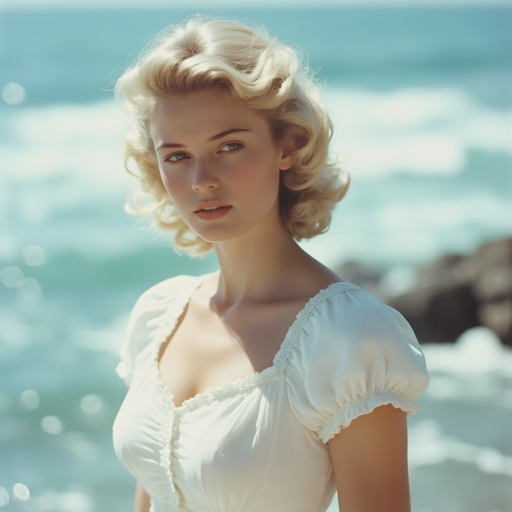

In [26]:
im = Image.open(image).convert("RGB")
print(im.size)
new_width =  int(size_widget.value.split('*')[0])
new_height = int(size_widget.value.split('*')[1])

if im.size[1] > im.size[0]:
    im = im.resize(( new_height, int(im.size[1]/im.size[0] * new_height)))
else:
    im = im.resize(( int(im.size[0]/im.size[1] * new_width), new_width))
width, height = im.size   # Get dimensions
print(im.size)



left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

# Crop the center of the image
im = im.crop((left, top, right, bottom))
im

In [27]:
size = size_widget.value
sample_steps = int(steps_widget.value)
frame_num = int(frame_widget.value)
sample_shift =  5.0 # if "i2v" not in task or size not in ["832*480", "480*832"] else 3.0

if lora_name != 'None':
    trigger_words = [v for k, v in lora_name_to_tag.items() if k in lora_name][0]
    prompt = f"{trigger_words} {prompt}"
    
else:
    prompt += ' Camera zooms out.' #' Сamera performs 360 degree rotatation around the seagull.'
# Load prompt expander if needed
print(prompt)
if use_prompt_extend:
    if prompt_extend_method == "dashscope":
        prompt_expander = DashScopePromptExpander(is_vl="i2v" in task)
    elif prompt_extend_method == "local_qwen":
        prompt_expander = QwenPromptExpander(is_vl="i2v" in task, device=rank)
    else:
        raise ValueError(f"Unsupported prompt_extend_method: {prompt_extend_method}")

    print("Extending prompt...")
    prompt_output = prompt_expander(
        prompt,
        tar_lang=prompt_extend_target_lang,
        image=Image.open(image).convert("RGB") if "i2v" in task else None,
        seed=base_seed,
    )
    if not prompt_output.status:
        print(f"Extending prompt failed: {prompt_output.message}")
        print("Falling back to original prompt.")
    else:
        prompt = prompt_output.prompt
    print(f"Extended prompt: {prompt}")

if "t2v" in task or "t2i" in task:
    print(f"Generating {'image' if 't2i' in task else 'video'}...")
    output = pipe.generate(
        prompt,
        size=SIZE_CONFIGS[size],
        frame_num=frame_num,
        shift=sample_shift,
        sample_solver="unipc",
        sampling_steps=sample_steps,
        guide_scale=5.0,
        seed=base_seed,
    )
else:
    print("Generating video...")
    im = Image.open(image).convert("RGB")
    if im.size[1] > im.size[0]:
        im = im.resize(( 512, int(im.size[1]/im.size[0] * 512)))
    else:
        im = im.resize(( int(im.size[0]/im.size[1] * 512), 512))

    new_width = 512
    new_height = 512
    width, height = im.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))

    output = pipe.generate(
        prompt,
        im,
        max_area=MAX_AREA_CONFIGS[size],
        frame_num=frame_num,
        shift=sample_shift,
        sample_solver="unipc",
        sampling_steps=sample_steps,
        guide_scale=5.0,
        seed=base_seed,
    )

CR4$h Z00M0UT A white-haired maiden wearing a white dress by the sea. The beach is peaceful. Ultra-HD, hyper detailed.
Generating video...


100%|██████████| 40/40 [03:57<00:00,  5.93s/it]


In [28]:
lora_path

'/home/jovyan/dmitrienko/workspace/checkpoints/wan14b_i2v/higgsfield_crash_zoom_out_480_lora128_lr1e-4_bs2_2gpus/20250405_18-33-10/epoch50/adapter_model.safetensors'

In [29]:
if lora_path != 'None':
    save_dir = f"examples/outputs/{task}_{lora_name}_{size}/{lora_path.split('/')[-2] if lora_path.split('/')[-2] != '' else lora_path.split('/')[-3]}"
else:
    save_dir = f"examples/outputs/{task}_{lora_name}_{size}/"
# save_dir = f'examples/outputs/{task}_14B/'
os.makedirs(save_dir, exist_ok=True)

suffix = ".png" if "t2i" in task else ".mp4"
formatted_time = datetime.now().strftime("%Y%m%d_%H%M%S")
formatted_prompt = prompt.replace(" ", "_").replace("/", "_")[:100]
save_file = f"lorascale{lora_scale}_{sample_steps}steps_{formatted_prompt}_{formatted_time}{suffix}"
save_file = os.path.join(save_dir, save_file)
save_file

'examples/outputs/i2v-14B_i2v_CR4$h_Z00M0UT_480_r128_lr1e-4_bs2_512*512/epoch50/lorascale1.0_40steps_CR4$h_Z00M0UT_A_white-haired_maiden_wearing_a_white_dress_by_the_sea._The_beach_is_peaceful._Ultra-H_20250415_153834.mp4'

In [30]:
# Save output
if "t2i" in task:
    print(f"Saving generated image to {save_file}")
    cache_image(output.squeeze(1)[None], save_file, nrow=1, normalize=True, value_range=(-1, 1))
else:
    print(f"Saving generated video to {save_file}")
    cache_video(output[None], save_file, fps=cfg.sample_fps, nrow=1, normalize=True, value_range=(-1, 1))

Saving generated video to examples/outputs/i2v-14B_i2v_CR4$h_Z00M0UT_480_r128_lr1e-4_bs2_512*512/epoch50/lorascale1.0_40steps_CR4$h_Z00M0UT_A_white-haired_maiden_wearing_a_white_dress_by_the_sea._The_beach_is_peaceful._Ultra-H_20250415_153834.mp4


In [31]:
# Display video in Jupyter Notebook
from IPython.display import Video
Video(save_file)

In [21]:
# Display video in Jupyter Notebook
from IPython.display import Video
Video(save_file, width=832)

In [25]:
# Display video in Jupyter Notebook
from IPython.display import Video
Video(save_file, width=832)

In [14]:
def generate_videos(prompts, images=None, sample_steps=None, output_dir='outputs'):
    size = size_widget.value
    if sample_steps is None:
        sample_steps = int(steps_widget.value)
    frame_num = int(frame_widget.value)
    sample_shift =  5.0 if "i2v" not in task or size not in ["832*480", "480*832"] else 3.0
    save_files = []
    for i, prompt in enumerate(prompts):
        if lora_name != 'None':
            trigger_words = [v for k, v in lora_name_to_tag.items() if k in lora_name][0]
            prompt = f"{trigger_words} {prompt}"

        # Load prompt expander if needed
        if use_prompt_extend:
            if prompt_extend_method == "dashscope":
                prompt_expander = DashScopePromptExpander(is_vl="i2v" in task)
            elif prompt_extend_method == "local_qwen":
                prompt_expander = QwenPromptExpander(is_vl="i2v" in task, device=rank)
            else:
                raise ValueError(f"Unsupported prompt_extend_method: {prompt_extend_method}")

            print("Extending prompt...")
            prompt_output = prompt_expander(
                prompt,
                tar_lang=prompt_extend_target_lang,
                image=Image.open(image).convert("RGB") if "i2v" in task else None,
                seed=base_seed,
            )
            if not prompt_output.status:
                print(f"Extending prompt failed: {prompt_output.message}")
                print("Falling back to original prompt.")
            else:
                prompt = prompt_output.prompt
            print(f"Extended prompt: {prompt}")

        if "t2v" in task or "t2i" in task:
            print(f"Generating {'image' if 't2i' in task else 'video'}...")
            output = pipe.generate(
                prompt,
                size=SIZE_CONFIGS[size],
                frame_num=frame_num,
                shift=sample_shift,
                sample_solver="unipc",
                sampling_steps=sample_steps,
                guide_scale=5.0,
                seed=base_seed,
            )
        else:
            print("Generating video...")
            if images is not None:
                image = images[i]
            
            im = Image.open(image).convert("RGB")
            print(im.size)
            if im.size[1] > im.size[0]:
                im = im.resize(( 512, int(im.size[1]/im.size[0] * 512)))
            else:
                im = im.resize(( int(im.size[0]/im.size[1] * 512), 512))
            width, height = im.size   # Get dimensions
            print(im.size)

            new_width = 512
            new_height = 512

            left = (width - new_width)/2
            top = (height - new_height)/2
            right = (width + new_width)/2
            bottom = (height + new_height)/2

            # Crop the center of the image
            im = im.crop((left, top, right, bottom))
            print(im.size)
            output = pipe.generate(
                prompt,
                im,
                max_area=MAX_AREA_CONFIGS[size],
                frame_num=frame_num,
                shift=sample_shift,
                sample_solver="unipc",
                sampling_steps=sample_steps,
                guide_scale=5.0,
                seed=base_seed+2,
            )
        
        save_dir = f"examples/{output_dir}/{task}_{lora_name}_{size}/{lora_path.split('/')[-2] if lora_path.split('/')[-2] != '' else lora_path.split('/')[-3]}"
        os.makedirs(save_dir, exist_ok=True)

        suffix = ".png" if "t2i" in task else ".mp4"
        formatted_time = datetime.now().strftime("%Y%m%d_%H%M%S")
        formatted_prompt = prompt.replace(" ", "_").replace("/", "_")[:100]
        save_file = f"lorascale{lora_scale}_{sample_steps}steps_{formatted_prompt}_{formatted_time}{suffix}"
        save_file = os.path.join(save_dir, save_file)

        # Save output
       
        if "t2i" in task:
            print(f"Saving generated image to {save_file}")
            cache_image(output.squeeze(1)[None], save_file, nrow=1, normalize=True, value_range=(-1, 1))
        else:
            print(f"Saving generated video to {save_file}")
            cache_video(output[None], save_file, fps=cfg.sample_fps, nrow=1, normalize=True, value_range=(-1, 1))
    return save_files

In [15]:
article_prompts = [
    "A 3D-rendered New Year's celebration scene shows a crowd with their backs to the camera, gazing up at fireworks blooming in the night sky. The massive '2025' digits, composed of dazzling fireworks, illuminate the entire shy. People are dressed in various winter outfits, with different postures -some have their arms crossed over their chests, while others raise their phones to capture the moment. In the background, the silhouette of the city is visible, with skyscrapers and trees faintly outlined. At the instant the fireworks explode, the crowd falls into an unusual stillness, collectively welcoming the arrival of the new year: Long shot, viewed from a low-angle perspective.",
    "A surrealist digital illustration features a relaxed white cat wearing pink wireless headphones, immersed in its own musical world. Its pointy ears gently press against a pair of pink sunglasses, adding a touch of fashion. The cat is skillfully blowing a transparent bubblegum bubble with its front paw, the bubble swaying lightly in the air as it reaches its maximum size. The background is a soft, pure pink, creating a dreamlike atmosphere. The cat's eyes are slightly open, exuding an expression of contentment and enjoyment, as if the entire world has turned sweet. A close-up shot focuses on the moment the cat blows the bubble, capturing the serenity and playfulness of the scene. In a near view, from an eye-level perspective, the details of the cat's facial expressions and movements are emphasized.",
    "A summer ocean scenery video features an elegant woman wearing a light beige sleeveless top, seated in a retro wooden cabin. Behind her lies a shimmering azure sea and distant misty emerald islands. Her wavy golden hair flows freely in the wind, resting gently on her shoulders. Sunlight streams through the porthole, illuminating her warm smile as she faces the camera sideways, her elbow resting lightly on the seat in a relaxed and charming posture. Outside the window, a clear sky dotted with a few leisurely white clouds creates a serene and carefree atmosphere. The high-definition video captures every ray of sunlight and every detail of the waves, showcasing the romantic allure of summer sailing. A close-up shot of the woman facing the camera sideways is paired with expansive seascapes filmed using a wide-angle lens.",
    "A dreamlike garden scene in digital art style features an orange-and-black butterfly gracefully fluttering in the air, surrounded by several translucent pink butterflies. The vibrant pink flowers in full bloom have delicate petals, golden stamens, and fresh green leaves. The background of a blue shy filled with shimmering light creates a fairy-tale-like atmosphere. In a close-up shot with the camera slightly tilted upward, the interaction between the butterflies and the flowers is captured, filling the entire frame with life and energy.",
    "A dynamic video scene captures a passionate street artist immersed in playing the violin against a pure white background. He wears a wide-brimmed straw hat, its brim gently shading his bright eyes, and dresses in a simple white shint paired with retro brown trousers. A saxophone hangs sty lishly at his waist, adding a touch of effortless charm. The antist's fingers move nimbly across the strings, fully absorbed in the music, his face radiating a deep love and dedication for his craft. The surrounding blank space stretches infinitely, as if the entire world is immersed in his melody, tranquil and pure. In a medium shot, the camera captures the performer from the front, focusing on the moment of complete devotion.",
    "A modern art piece in 3D rendering style features a pink single-seat sofa chair placed on a smooth floor: The design of the sofa chair is minimalist, with a subtle granular texture on its surface. The background is a clear blue sky dotted with a few white clouds, creating an overall bright and fresh color palette. With no people in the scene, the sofa chair stands out prominently. The shot is taken in a medium view, with a slight rotation of the camera emphasizing the details and texture of the sof a chair.",
	"Retro cyberpunk style - Under flickering neon lights, a cyber warrior in a leather jacket passes through an abandoned electronics factory.",
    "The video shows a scene of a person in the post-apocalyptic world",
    'The video shows an aircraft flying above the clouds. The plane appears to be a private jet, identifiable by its sleek design and the registration number "N2000A" visible on the side of the fuselage. The aircraft is captured from a side angle, highlighting its wings and engines as it soars through the sky. The background consists of a mix of white and gray clouds, suggesting that the plane is at a high altitude. The lighting indicates that the scene might be taking place during either sunrise or sunset, as the light has a warm, golden hue.',
    "Solar system showing the planets rotating around the sun. The video should show the orbital paths of each planet on their axis. The sun should have visible solar flares.",
    "Two anthropomorphic cats in comfy boxing gear and bright gloves fight intensely on a spotlighted stage.",
    "Summer beach vacation style, a white cat wearing sunglasses sits on a surfboard. The fluffy-furred feline gazes directly at the camera with a relaxed expression. Blurred beach scenery forms the background featuring crystal-clear waters, distant green hills, and a blue sky dotted with white clouds. The cat assumes a naturally relaxed posture, as if savoring the sea breeze and warm sunlight. A close-up shot highlights the feline's intricate details and the refreshing atmosphere of the seaside.",

]

prompts = [
    "A high-resolution cinematic video of a seagull standing on a stone ledge near a canal in a European city. The seagull moves its head, looks around, and occasionally flaps its wings. The scene is illuminated by natural daylight, creating a lively urban atmosphere.",
    'A cinematic video of an old red telephone booth with a WiFi sign, standing alone on a quiet city street. Occasional pedestrians and cars pass by, adding a subtle urban atmosphere.',
    "Chinese ancient tower in the courtyard of a traditional Chinese temple.",
    'The towering, realistic Gundam mecha is standing in an open square under a clear blue sky. ',
]

images = [
    '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/photo_2025-04-01_16-22-03.jpg',
    '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/photo_2025-04-01_16-22-07.jpg',
    '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/photo_2025-04-01_16-22-10.jpg',
    '/home/jovyan/dmitrienko/workspace/diffusion-pipe_dmitrienko/Wan2_1/examples/images/photo_2025-04-01_16-22-13.jpg',

]


In [16]:
generate_videos(prompts, images, sample_steps=40, output_dir='outputs')

Generating video...
(960, 1280)
(512, 682)
(512, 512)


 70%|███████   | 28/40 [02:46<01:11,  5.93s/it]


KeyboardInterrupt: 